In [1]:

#%tensorflow_version 2.x  # this line is not required unless you are in a notebook
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

keras = tf.keras

print(tf.__version__)


2.7.0


In [2]:
#make cell to initilize some things (numaugs) and onlytwo
onlytwo=1 # if 0 uses all 5 classes; if 1, uses 0 for 0 and 1 for classes 1 thru 4
numaugs = 0 # number of augmentations of each image
ll1=.05 #weight l1 regularization (default is .01)
#number of images to extract from folder
kkk=1600
dropoutrate=0.35 #dropout rate before last layer
batchsizenn=160 #160
initial_epochs = 50 #epochs to train the CNN
Cropped=1 # 1 for using cropped images, 0 for not.


In [3]:
import os

#from google.colab import drive
#drive.mount('/content/drive/')

if Cropped==0:
    data = pd.read_csv (os.getcwd()+'/trainLabels.csv')   #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"

if Cropped==1:
    data = pd.read_csv (os.getcwd()+'/trainLabels_cropped.csv')   #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"

print (data)

filenames=data['image']
labels=data['level']
keys=np.arange(0,len(labels)) # label fundus images 0 thru the end



labels=labels[0:kkk]
filenames=filenames[0:kkk]
keys=keys[0:kkk]

#0 - no DR, 1,2,3,4 - DR
#print(labels)
if onlytwo == 1:
    labels = labels != 0 
    labels=labels.astype(int)

print(np.amax(labels),np.amin(labels))

#print(labels)

print(labels.shape)


       Unnamed: 0  Unnamed: 0.1        image  level
0               0             0      10_left      0
1               1             1     10_right      0
2               2             2      13_left      0
3               3             3     13_right      0
4               4             4      15_left      1
...           ...           ...          ...    ...
35103       35104         35121  44347_right      0
35104       35105         35122   44348_left      0
35105       35106         35123  44348_right      0
35106       35107         35124   44349_left      0
35107       35108         35125  44349_right      1

[35108 rows x 4 columns]
1 0
(1600,)


In [4]:

import matplotlib.image as mpimg
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#size of images n by m by p=3 for RGB (needed with some pretrained networks)
n=150
m=150
p=3 

#fundus=np.zeros((n*m,35126),dtype=np.uint8).reshape(n*m,35126) #CHANGE THIS LATER

fundus=np.zeros((n*m*p,kkk),dtype=np.uint8).reshape(n*m*p,kkk) #CHANGE THIS LATER

size=n*m*p

#print(fundus.shape)
for ii in np.arange(len(filenames)):
    #print(ii)
    #need filename specific to computer
    if Cropped==0:
        f2=np.array(mpimg.imread('C:\\Users\\march\\Documents\\UIUC\\BIOE485\\MPProject\\resized_train\\resized_train\\'+filenames[ii]+'.jpeg'))#.reshape(-1,1)

    if Cropped==1:
        f2=np.array(mpimg.imread('C:\\Users\\march\\Documents\\UIUC\\BIOE485\\MPProject\\resized_train_cropped\\resized_train_cropped\\'+filenames[ii]+'.jpeg'))#.reshape(-1,1)
    
    f=f2[0:,0:,0:].reshape(f2.shape[0],f2.shape[1],-1)
    del f2
    # to crop, take the middle part, also taking one color to make grayscale
    #s0=f.shape[0]
    #s1=f.shape[1]
    #print(np.floor((s0-n)/2).astype(int))
    #print(np.floor((s0-m)/2).astype(int))
    
    #for shrinking images
    #fundus[0:,ii]= f[np.floor((s0-n)/2).astype(int):np.floor((s0-n)/2+n).astype(int),np.floor((s1-m)/2).astype(int):np.floor((s1-m)/2+m).astype(int),1].reshape(-1)
    
    #for zero padding
    #print(f.size)
    #print(size)

    #fundus[0:,ii]=np.append(f[0:,0:,1].reshape(-1),np.zeros((size-f[0:,0:,1].size,1))).reshape(-1)

    fundus[0:,ii] = tf.image.resize(f, (n,m)).reshape(n*m*p)

    
    
    #take the G of the RGB?
    del f # so more memory space can be freed up
    #del s0
    #del s1

#fundussave=fundus.copy()


In [5]:

#  LOAD AND SPLIT DATASET
#(train_images, train_labels), (test_images, test_labels) = 
#Use labeled fundes images to create a classifier
#train the classifier using SGD or nesterov

#Randomly split the dataset
#Use 80%, 20%
np.random.shuffle(keys)

train_set = keys[0:int(0.8*len(keys))]
test_set = keys[int(0.8*len(keys)):]

print(len(train_set), len(test_set))

train_images=np.zeros((len(train_set),n,m,p))
test_images=np.zeros((len(test_set),n,m,p))
train_labels=np.zeros((len(train_set)))
test_labels=np.zeros((len(test_set)))

for i in np.arange(len(train_set)):
    train_images[i,0:,0:,0:]=fundus[0:,train_set[i]].reshape(n,m,p)
    train_labels[i]=labels[train_set[i]]
for i in np.arange(len(test_set)):
    test_images[i,0:,0:,0:]=fundus[0:,test_set[i]].reshape(n,m,p)
    test_labels[i]=labels[test_set[i]]
del fundus
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['0 no DR detectable','1 mild','2 moderate','3 severe','4 very severe']

print(np.amax(train_images))
print(np.amin(train_images))

print(train_images.shape)





1280 320
1.0
0.0
(1280, 150, 150, 3)


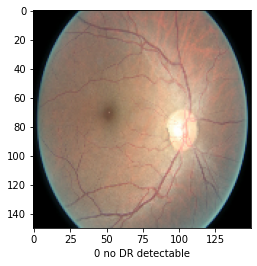

In [6]:

# Let's look at a one image
IMG_INDEX = 4  # change this to look at other images

plt.imshow(train_images[IMG_INDEX] ,cmap=plt.cm.binary)
#plt.xlabel(class_names[train_labels[IMG_INDEX][0]])
plt.xlabel(class_names[train_labels[IMG_INDEX].astype(int)])

plt.show()


In [7]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


#MIGHT HAVE TO FIX IF NUMAUGS NOT 0 FOR RGB VALUES WITH 3 CHANNELS

# have img2 here, may need del or need to remove this part if numaugs==0, but it is initialize below
if numaugs !=0:

    # creates a data generator object that transforms images
    datagen = ImageDataGenerator(
    rotation_range=0.2,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

    img2=np.zeros((1,n,m,p,len(train_set)))

    for i in np.arange(len(train_set)):
    # pick an image to transform
        #test_img = train_images[i,0:,0:]
        img = image.img_to_array(train_images[i,0:,0:,0:])  # convert image to numpy arry
        #print(img.shape)
        img = img.reshape((1,) + img.shape)  # reshape image
        #print(img.shape)
        img2[0,0:,0:,0:,i]=img[0,0:,0:,0:] #right shape? 0 on left delete?
        del img
    print(img2.shape)

    print(i)
    #train_images2=datagen.flow(img, save_prefix='test', save_format='jpeg')

    print(img2[0,0:,0:,0:,0].reshape(1,n,m,p,1).shape)

    i = 0

    for batch in datagen.flow(img2[0,0:,0:,0:,IMG_INDEX].reshape(1,n,m,p), save_prefix='test', save_format='jpeg'):  # this loops runs forever until we break, saving images to current directory with specified prefix
        plt.figure(i)
        plot = plt.imshow(image.img_to_array(batch[0]),cmap=plt.cm.binary)
        print(image.img_to_array(batch[0]).shape)
        i += 1
        #train_images2=batch()
        if i > 2-1:  # show 4 images
            break

    plt.show()

    #train_images2.shape

    print(img2.shape)

    #plt.figure(5)
    #plot = plt.imshow(img2[0,0:,0:,0])
    
    

In [8]:
#might need a del here
#del train_images
# 


if numaugs != 0:
    
#increase amount of training data
    img3=np.zeros((n,m,p,len(train_set),numaugs))
    for ii in np.arange(len(train_set)):
        i = 0
        for batch in datagen.flow(img2[0,0:,0:,0:,ii].reshape(1,n,m,p), save_prefix='test', save_format='jpeg'):  # this loops runs forever until we break, saving images to current directory with specified prefix
        #add in alternative if want none? if statement should work
            img3[0:,0:,0:,ii,i]=image.img_to_array(batch[0]).reshape(n,m,p)
            i += 1
    #train_images2=batch()
            if i > numaugs-1:  
                break
            
    del img2
            

    print(img3.shape)
    plt.figure()
    plot = plt.imshow(img3[0:,0:,0:,0,0],cmap=plt.cm.binary)
    img3=img3.reshape(n,m,p,numaugs*len(train_set))

#permute to right shape

#train_images[(len(train_set)+1):(len(train_set)*2),0:,0:]=np.transpose(img3, (2, 0, 1))

#need loop for more numaugs
    print(train_images.shape)
    print(np.transpose(img3, (3, 0, 1, 2)).shape)
    train_images=np.append(train_images,np.transpose(img3, (3, 0, 1, 2)),axis=0)


    del img3
    print(train_images.shape)

#repeat training labels for augmented images
    train_labels=np.tile(train_labels,numaugs+1)
    print(train_labels.shape)



0.0


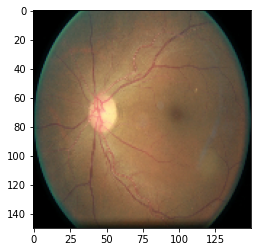

In [9]:
#x=np.array([[1,2,3],[4,5,6],[7,8,9]])
#print(x)
#x=np.append(x,[[10,11,12],[13,14,15],[16,17,18]],axis=0)
#print(x)

#view images again


pp=7
plt.figure()
plot = plt.imshow(train_images[pp,0:,0:,0:])#,cmap=plt.cm.binary)
print(train_labels[pp])

if numaugs != 0:
    plt.figure()
    plot = plt.imshow(train_images[pp+len(train_set),0:,0:],cmap=plt.cm.binary)
    print(train_labels[pp+len(train_set)])


In [10]:
#end of data augmentation stuff

In [11]:
IMG_SHAPE = (n, m, p)

# Create the base model from the pre-trained model MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                               include_top=False,
#                                               weights='imagenet')


#use inceptionv3 like other people did.see paper
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3
#change pooling?
base_model=tf.keras.applications.inception_v3.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=IMG_SHAPE, pooling=max,
    classifier_activation='softmax'
)



In [12]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [13]:
base_model.trainable = False # freeze the pretrained neural net


In [14]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() #add pooling layer

In [16]:

#did some thigs myself here with the softmax, not sure if it makes any sense

#kernal_regularizeor should help prevent overfitting

#preprediction = keras.layers.Dense(5)
if onlytwo == 0:
    prediction_layer = keras.layers.Dense(5,activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(ll1)) # how many neurons? 1 for 2 classes, not sure for 5 - may need 
#to change loss function and last output layer to softmax for 5 classes
#add another softmax for confusion matrix being used??

if onlytwo == 1:
    prediction_layer = keras.layers.Dense(2,activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(ll1)) # how many neurons? 1 for 2 classes, not sure for 5 - may ne



In [17]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer, #remove this?
    #add dropout layer to prevent memorization of data, enforces network to consider more neurons before it
  tf.keras.layers.Dropout(dropoutrate),
    #regularizer somewhere??
    

  prediction_layer
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [19]:
#base_learning_rate = 0.0001
#model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy','mse','mae'])

#SGD known to generalize better from a paper (switch to SGD from adam)
#adam is optimized SGD, switch back

#opt = tf.keras.optimizers.SGD(learning_rate=0.1)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy','mse'])

In [20]:
# We can evaluate the model right now to see how it does before training it on our new images

#loss0, accuracy0 = model.evaluate(test_images,test_labels)
print(model.evaluate(test_images,test_labels))



10/10 [==============================] - 5s 384ms/step - loss: 6.7715 - accuracy: 0.4094 - mse: 0.3426
[6.771456718444824, 0.40937501192092896, 0.34263181686401367]


In [21]:
predictionstest = model.predict(test_images)
predictionstrain = model.predict(train_images)

print(predictionstest.shape)
#print(predictionstest)

#change argmax if data is not set up in a way where it makes sense??


predictDRtest=tf.math.argmax(
    predictionstest, axis=1, output_type=tf.dtypes.int64, name=None
)
#print(predictDRtest)

predictDRtrain=tf.math.argmax(
    predictionstrain, axis=1, output_type=tf.dtypes.int64, name=None
)



(320, 2)


Testing data confusion matrix
tf.Tensor(
[[ 52 177]
 [ 12  79]], shape=(2, 2), dtype=int32)
Training data confusion matrix
tf.Tensor(
[[188 761]
 [ 59 272]], shape=(2, 2), dtype=int32)


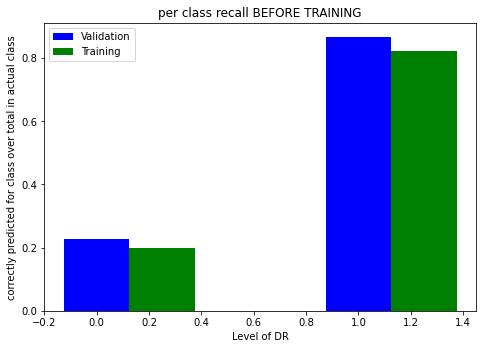

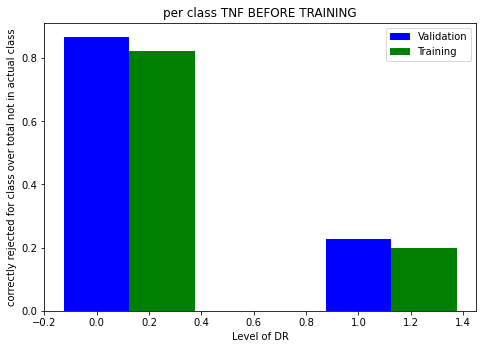

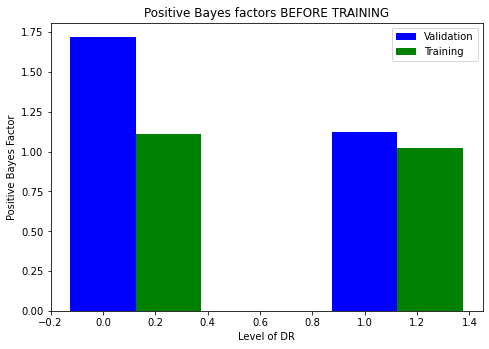

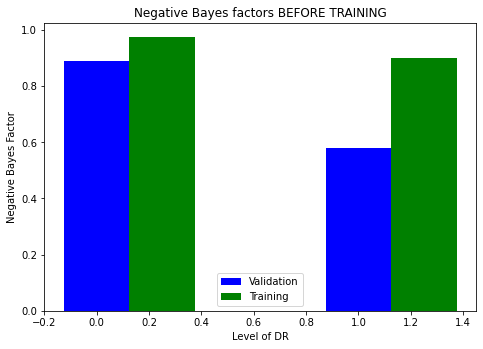

In [22]:
#make with reject for TNF measurement too


cmtest=tf.math.confusion_matrix(test_labels,predictDRtest)
cmtrain=tf.math.confusion_matrix(train_labels,predictDRtrain)

print('Testing data confusion matrix')
print(cmtest)
if onlytwo == 0:
    nnn=5
if onlytwo == 1:
    nnn=2

#testrecall=np.zeros(nnn)
#trainrecall=np.zeros(nnn)
recall=np.zeros((2,nnn))
reject=np.zeros((2,nnn))

    
for i in np.arange(nnn):
    #print(i)
    #print(cmtest[i,i]/np.sum(cmtest,axis=0)[i])
    #testrecall[i]=cmtest[i,i]/np.sum(cmtest,axis=0)[i]
    recall[0,i]=cmtest[i,i]/np.sum(cmtest,axis=1)[i]
    
    holder=np.sum(cmtest,axis=1)#
    holder2=np.sum(cmtest,axis=0)
    reject2=(np.sum(holder)-holder[i])# # of actual negatives
    reject[0,i]=(reject2-holder2[i]+cmtest[i,i])/reject2 # # of actual and predicted negatives


print('Training data confusion matrix')
print(cmtrain)
for i in np.arange(nnn):
    #print(i)
    #print(cmtrain[i,i]/np.sum(cmtrain,axis=0)[i])
    #trainrecall[i]=cmtrain[i,i]/np.sum(cmtrain,axis=0)[i]
    recall[1,i]=cmtrain[i,i]/np.sum(cmtrain,axis=1)[i]
    
    #reject[1,i]=cmtrain[i,i]/np.sum(cmtrain,axis=0)[i]
    
    holder=np.sum(cmtrain,axis=1)#
    holder2=np.sum(cmtrain,axis=0)
    reject2=(np.sum(holder)-holder[i])# # of actual negatives
    reject[1,i]=(reject2-holder2[i]+cmtrain[i,i])/reject2 # # of actual and predicted negatives

fig = plt.figure()
X = np.arange(nnn)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, recall[0,0:], color = 'b', width = 0.25)
ax.bar(X + 0.25, recall[1,0:], color = 'g', width = 0.25)
ax.set_title('per class recall BEFORE TRAINING')
ax.legend(labels=['Validation', 'Training'])
ax.set_xlabel('Level of DR')
ax.set_ylabel('correctly predicted for class over total in actual class')

fig = plt.figure()
X = np.arange(nnn)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, reject[0,0:], color = 'b', width = 0.25)
ax.bar(X + 0.25, reject[1,0:], color = 'g', width = 0.25)
ax.set_title('per class TNF BEFORE TRAINING')
ax.legend(labels=['Validation', 'Training'])
ax.set_xlabel('Level of DR')
ax.set_ylabel('correctly rejected for class over total not in actual class')
    

Bayestest=np.zeros((2,nnn))
Bayestrain=np.zeros((2,nnn))

for i in np.arange(nnn):
    Bayestest[0,i]=recall[0,i]/(1-reject[0,i])
    Bayestrain[0,i]=recall[1,i]/(1-reject[1,i])
    
    Bayestest[1,i]=(1-recall[0,i])/reject[0,i]
    Bayestrain[1,i]=(1-recall[1,i])/reject[1,i]


fig = plt.figure()
X = np.arange(nnn)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, Bayestest[0,0:], color = 'b', width = 0.25)
ax.bar(X + 0.25, Bayestrain[0,0:], color = 'g', width = 0.25)
ax.set_title('Positive Bayes factors BEFORE TRAINING')
ax.legend(labels=['Validation', 'Training'])
ax.set_xlabel('Level of DR')
ax.set_ylabel('Positive Bayes Factor')


fig = plt.figure()
X = np.arange(nnn)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, Bayestest[1,0:], color = 'b', width = 0.25)
ax.bar(X + 0.25, Bayestrain[1,0:], color = 'g', width = 0.25)
ax.set_title('Negative Bayes factors BEFORE TRAINING')
ax.legend(labels=['Validation', 'Training'])
ax.set_xlabel('Level of DR')
ax.set_ylabel('Negative Bayes Factor')

del recall
del cmtrain
del cmtest
del holder
del holder2
del Bayestest
del Bayestrain


In [23]:
# Now we can train it on our images

if onlytwo == 0:
    class_weights = {0: 1., # tell it to pay more attention to rare classes - 
                    1: 10., # use balanced mini-batch instead?
                    2: 5.,
                    3: 29.,
                    4: 33.}

if onlytwo == 1: # for binary classification
    class_weights = {0: 1., # tell it to pay more attention to rare classes - 
                    1: 2.7, # use balanced mini-batch instead?
                    }



history = model.fit(train_images, train_labels,
                    batch_size = batchsizenn, #defaults to 32, change?
                    epochs=initial_epochs,
                    validation_data=(test_images,test_labels),
                   class_weight=class_weights)


Epoch 1/50
8/8 [==============================] - 24s 3s/step - loss: 7.2352 - accuracy: 0.4977 - mse: 0.3794 - val_loss: 5.8254 - val_accuracy: 0.6313 - val_mse: 0.3219
Epoch 2/50
8/8 [==============================] - 21s 3s/step - loss: 6.5810 - accuracy: 0.5133 - mse: 0.3634 - val_loss: 5.6046 - val_accuracy: 0.4281 - val_mse: 0.3024
Epoch 3/50
8/8 [==============================] - 23s 3s/step - loss: 5.8846 - accuracy: 0.5602 - mse: 0.3541 - val_loss: 5.0884 - val_accuracy: 0.4750 - val_mse: 0.2951
Epoch 4/50
8/8 [==============================] - 25s 3s/step - loss: 5.3989 - accuracy: 0.5453 - mse: 0.3510 - val_loss: 4.4180 - val_accuracy: 0.6438 - val_mse: 0.3083
Epoch 5/50
8/8 [==============================] - 25s 3s/step - loss: 4.8399 - accuracy: 0.5539 - mse: 0.3443 - val_loss: 3.9597 - val_accuracy: 0.6875 - val_mse: 0.3157
Epoch 6/50
8/8 [==============================] - 24s 3s/step - loss: 4.5701 - accuracy: 0.5492 - mse: 0.3510 - val_loss: 3.6664 - val_accuracy: 0.553

In [24]:
#model.predict()
# https://www.tensorflow.org/guide/keras/train_and_evaluate
predictionstest = model.predict(test_images)

del test_images

predictionstrain = model.predict(train_images)

#print(predictions.shape)
#print(predictions)

predictDRtest=tf.math.argmax(
    predictionstest, axis=1, output_type=tf.dtypes.int64, name=None
)
#print(predictDR)

predictDRtrain=tf.math.argmax(
    predictionstrain, axis=1, output_type=tf.dtypes.int64, name=None
)



Testing data confusion matrix
tf.Tensor(
[[ 91 138]
 [ 23  68]], shape=(2, 2), dtype=int32)
Training data confusion matrix
tf.Tensor(
[[403 546]
 [ 60 271]], shape=(2, 2), dtype=int32)


Text(0, 0.5, 'Negative Bayes Factor')

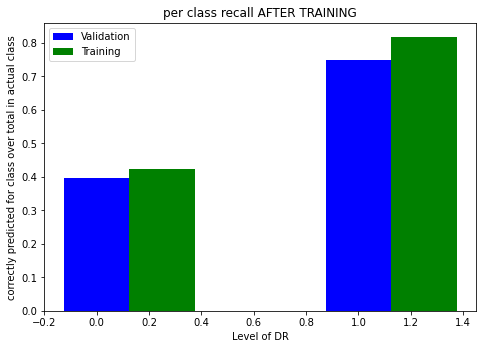

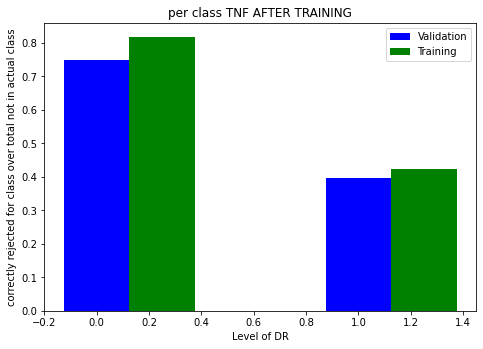

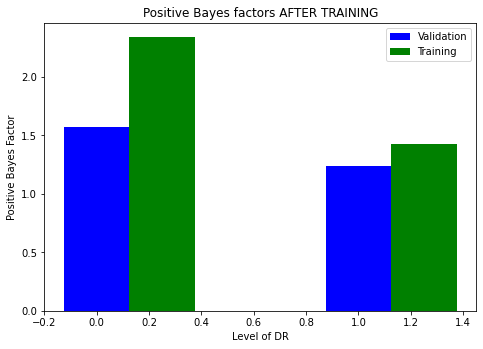

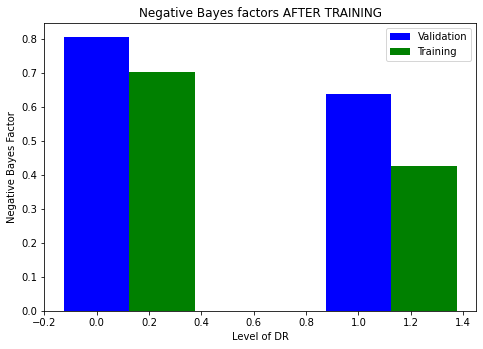

In [25]:
#After training
#plots actual on the rows and predicted as the colums
cmtest=tf.math.confusion_matrix(test_labels,predictDRtest)
cmtrain=tf.math.confusion_matrix(train_labels,predictDRtrain)

print('Testing data confusion matrix')
print(cmtest)
if onlytwo == 0:
    nnn=5
if onlytwo == 1:
    nnn=2

recall=np.zeros((2,nnn))
reject=np.zeros((2,nnn))


for i in np.arange(nnn):
    recall[0,i]=cmtest[i,i]/np.sum(cmtest,axis=1)[i]

    holder=np.sum(cmtest,axis=1)#
    holder2=np.sum(cmtest,axis=0)
    reject2=(np.sum(holder)-holder[i])# # of actual negatives
    reject[0,i]=(reject2-holder2[i]+cmtest[i,i])/reject2 # # of actual and predicted negatives


print('Training data confusion matrix')
print(cmtrain)
for i in np.arange(nnn):
    recall[1,i]=cmtrain[i,i]/np.sum(cmtrain,axis=1)[i]

    
    holder=np.sum(cmtrain,axis=1)#
    holder2=np.sum(cmtrain,axis=0)
    reject2=(np.sum(holder)-holder[i])# # of actual negatives
    reject[1,i]=(reject2-holder2[i]+cmtrain[i,i])/reject2 # # of actual and predicted negatives
    
fig = plt.figure()
X = np.arange(nnn)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, recall[0,0:], color = 'b', width = 0.25)
ax.bar(X + 0.25, recall[1,0:], color = 'g', width = 0.25)
ax.set_title('per class recall AFTER TRAINING')
ax.legend(labels=['Validation', 'Training'])
ax.set_xlabel('Level of DR')
ax.set_ylabel('correctly predicted for class over total in actual class')

fig = plt.figure()
X = np.arange(nnn)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, reject[0,0:], color = 'b', width = 0.25)
ax.bar(X + 0.25, reject[1,0:], color = 'g', width = 0.25)
ax.set_title('per class TNF AFTER TRAINING')
ax.legend(labels=['Validation', 'Training'])
ax.set_xlabel('Level of DR')
ax.set_ylabel('correctly rejected for class over total not in actual class')


#Bayes factor for each level? + bayes = TPR/FPR = recall/(1-reject)
#see https://www.youtube.com/watch?v=lG4VkPoG3ko 
#positive bayes - multiple by prior odds to get new odds if test positive
#nbays - multiple if test negative
Bayestest=np.zeros((2,nnn))
Bayestrain=np.zeros((2,nnn))

for i in np.arange(nnn):
    Bayestest[0,i]=recall[0,i]/(1-reject[0,i])
    Bayestrain[0,i]=recall[1,i]/(1-reject[1,i])
    
    Bayestest[1,i]=(1-recall[0,i])/reject[0,i]
    Bayestrain[1,i]=(1-recall[1,i])/reject[1,i]


fig = plt.figure()
X = np.arange(nnn)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, Bayestest[0,0:], color = 'b', width = 0.25)
ax.bar(X + 0.25, Bayestrain[0,0:], color = 'g', width = 0.25)
ax.set_title('Positive Bayes factors AFTER TRAINING')
ax.legend(labels=['Validation', 'Training'])
ax.set_xlabel('Level of DR')
ax.set_ylabel('Positive Bayes Factor')


fig = plt.figure()
X = np.arange(nnn)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, Bayestest[1,0:], color = 'b', width = 0.25)
ax.bar(X + 0.25, Bayestrain[1,0:], color = 'g', width = 0.25)
ax.set_title('Negative Bayes factors AFTER TRAINING')
ax.legend(labels=['Validation', 'Training'])
ax.set_xlabel('Level of DR')
ax.set_ylabel('Negative Bayes Factor')


In [26]:
#can use model.fit again? augment data and run again



In [27]:
#print(history)
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse'])


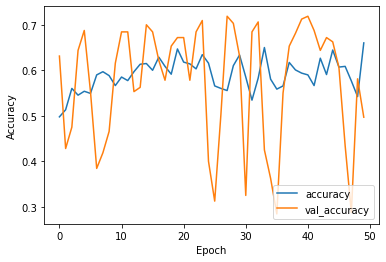

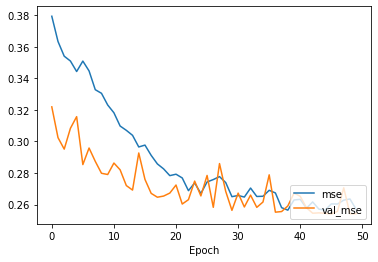

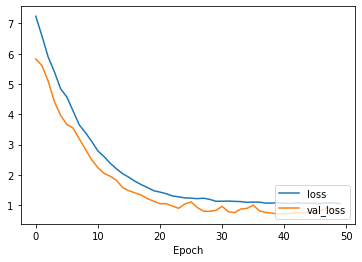

In [28]:
# https://www.tensorflow.org/tutorials/images/cnn#
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label = 'val_mse')
plt.xlabel('Epoch')
plt.ylabel('')
#plt.ylim([0, 1])
plt.legend(loc='lower right')


plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('')
#plt.ylim([0, 1])
plt.legend(loc='lower right')

